# Goal: Classify Genetic Variations using Text from Clinical Evidence
A team at Memorial Sloan Kettering Cancer Center (MSKCC) spends counless hours every year manually reviewing evidence to classify genetic mutations. Once the most important variants have been identified new therapies can be developed. Having a machine learning algorithm to automatically classify genetic variations would allow the development of therapies much sooner. This competition is a challenge to develop classification models which analyze abstracts of medical articles and, based on their content accurately determine mutation effect (9 classes) of the genes discussed in them. For more information, please refer to the Kaggle competition: https://www.kaggle.com/c/msk-redefining-cancer-treatment#description. 

Here is an article that also gives context to a project such as this and the impact could have: https://www.forbes.com/sites/matthewherper/2017/06/03/a-new-cancer-drug-helped-almost-everyone-who-took-it-almost-heres-what-it-teaches-us/#12aad9136b25. 

This task is complex and hard to elvaluate the cross val score due to the data only representing some of the genes in the dataset. In the end, if my score is not great, I hope to have been able to better understand the use of machine learning in genomic analysis and explore its limitations. 


Also, there was a 2nd phase to this competition due to the labels for the test data being released by a third party before the competition closed. I may want to combine the training data from both phases to train the model if I am not able to get a good score from just the initial data set. 

#### Target: 9 classes that represent different levels of whether or not the variant is a driver or passenger mutation.
These are the class labels from OncoKB, but using this text in the competition is prohibited. 
1. Likely Loss-of-function
2. Likely Gain-of-function
3. Neutral
4. Loss-of-function
5. Likely Neutral
6. Inconclusive
7. Gain-of-function
8. Likely Switch-of-function
9. Switch-of-function

Using COSMIC and Genotype-Phenotype associations are not allowed due to the point of this project being modeling text.

You are not allowed to use conservation scores, or predictors of deleterious or tolerated mutations (such as Polyphen) because these tools also try to predict the effect of a mutation (which is very close to the goal of this competition) but they don't use text to do it

##### Outside resources that have been approved by kaggle for use in this competition but not necessary:
 -  Gene–disease associations: http://ctdbase.org/
 -  Text data from:
    - Encyclopedia_of_Molecular_Cell_Biology_and_Molecular_Medicine_16_volumes_Wiley_2006_
    - Cell-Molecular-Biology-Concepts-Experiments 7th edition
 - MESH topics, as well as extended information about those articles
 - Pre-trained Bio-NER taggers (May need to map the variations to RSIDs and search related articles in PubMed or PMC):
    - tmVar https://www.ncbi.nlm.nih.gov/research/bionlp/Tools/tmvar/
    - TaggerOne https://www.ncbi.nlm.nih.gov/research/bionlp/Tools/taggerone/
    - GNormPlus https://www.ncbi.nlm.nih.gov/research/bionlp/Tools/gnormplus/
 - Pathway and protein information of each gene (e.g. GO).
 - Pubmed dictionaries of genes names.
 - Mygene api (http://docs.mygene.info/en/v3/doc/data.html) It contains a lot of information about genes (such as family, overall description, etc). 
 - Gene expression from The Human Protein Atlas project ( https://www.ebi.ac.uk/gxa/experiments/E-PROT-3/Downloads )
 - The aminoacid sequences for the genes in the dataset, in FASTA.
 - Other papers from PubMed in addition to the training_text in order to pre-train NLP model
 - Genia, an annotated treebank for parsing biomed papers(http://www.geniaproject.org/)
 - You can use variations themselves as features. For example a 'Deletion' in a gene may be more likely to be 1. Similar case could be made for amino acid changes. Some amino acid changes are more deleterious than others.
 - Google's trained Word2Vec models and pretrained models from bio.nlplab.org
 - Sequence data, mutation positition data and protein structure data from Uniport
 - allele frequency information from gnomAD or ExAC
 - controlled vocabularies to guide Named Entity Recognition modles. Examples: such as ICD, SNOMED CT,NCI Thesaurus, CPT, MedDRA, SNOMED CT
 
 Note from Kaggle: "We knew the task was very difficult, so Iker from MSK suggested that we allow external data, in case anyone wants to build a knowledge base for gene mutations."

---
# Imports

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

%matplotlib inline

In [27]:
train_var = pd.read_csv('Data/training_variants.zip')
train_txt = pd.read_csv('Data/training_text.zip', sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
test_var = pd.read_csv('Data/test_variants.zip')
test_txt = pd.read_csv('Data/test_text.zip', sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])

---
# EDA

---
### Training Variants

In [44]:
print(train_var.shape)
print(train_var.dtypes)
print(train_var.isnull().sum())
train_var.head()

(3321, 4)
ID            int64
Gene         object
Variation    object
Class         int64
dtype: object
ID           0
Gene         0
Variation    0
Class        0
dtype: int64


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [67]:
pd.DataFrame(train_var['Gene'].value_counts())

,Gene
BRCA1,264
TP53,163
EGFR,141
PTEN,126
BRCA2,125
KIT,99
BRAF,93
ERBB2,69
ALK,69
PDGFRA,60


In [75]:
pd.DataFrame(train_var['Variation'].value_counts())

,Variation
Truncating Mutations,93
Deletion,74
Amplification,71
Fusions,34
Overexpression,6
G12V,4
Q61R,3
T58I,3
E17K,3
Q61L,3


In [145]:
# I want to find out which gene the variations with only one occurance below to


In [90]:
train_var['Class'].value_counts()

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

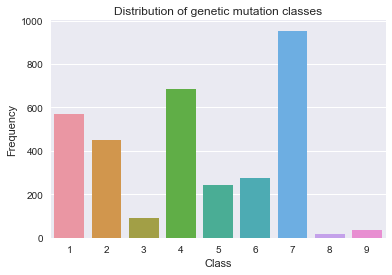

In [143]:
plt.figure()
sns.countplot(x="Class", data=train_var)
plt.ylabel('Frequency')
plt.xlabel('Class')
plt.title("Distribution of genetic mutation classes")
plt.show()

##### Looking at the genes with 50 or more occurances in the training data set

In [140]:
# BRCA1
BRCA1 = train_var.loc[train_var['Gene']=='BRCA1']
print(BRCA1['Class'].value_counts())

5    90
1    60
6    53
4    46
3    15
Name: Class, dtype: int64


In [138]:
# TP53
TP53 = train_var.loc[train_var['Gene']=='TP53']
print(TP53['Class'].value_counts())

1    83
4    67
6     5
2     3
5     2
3     2
9     1
Name: Class, dtype: int64


In [139]:
# EGFR
EGFR = train_var.loc[train_var['Gene']=='EGFR']
print(EGFR['Class'].value_counts())

7    84
2    45
4     5
5     3
8     1
6     1
3     1
1     1
Name: Class, dtype: int64


In [137]:
# PTEN
PTEN = train_var.loc[train_var['Gene']=='PTEN']
print(PTEN['Class'].value_counts())

4    115
3      5
1      3
5      2
7      1
Name: Class, dtype: int64


In [136]:
# BRCA2
BRCA2 = train_var.loc[train_var['Gene']=='BRCA2']
print(BRCA2['Class'].value_counts())

6    84
5    20
1    18
4     3
Name: Class, dtype: int64


In [135]:
# KIT
KIT = train_var.loc[train_var['Gene']=='KIT']
print(KIT['Class'].value_counts())

7    52
2    44
6     1
4     1
3     1
Name: Class, dtype: int64


In [134]:
# BRAF
BRAF = train_var.loc[train_var['Gene']=='BRAF']
print(BRAF['Class'].value_counts())

7    48
2    31
5     8
6     3
4     2
3     1
Name: Class, dtype: int64


In [133]:
# ERBB2
ERBB2 = train_var.loc[train_var['Gene']=='ERBB2']
print(ERBB2['Class'].value_counts())

7    30
2    14
6    12
5     6
4     5
8     1
1     1
Name: Class, dtype: int64


In [131]:
# ALK
ALK = train_var.loc[train_var['Gene']=='ALK']
print(ALK['Class'].value_counts())

7    47
3    10
2     7
5     5
Name: Class, dtype: int64


In [130]:
# PDGFRA
PDGFRA = train_var.loc[train_var['Gene']=='PDGFRA']
print(PDGFRA['Class'].value_counts())

7    42
3     9
5     4
2     3
4     1
1     1
Name: Class, dtype: int64


In [129]:
# PIK3CA
PIK3CA = train_var.loc[train_var['Gene']=='PIK3CA']
print(PIK3CA['Class'].value_counts())

7    31
2    14
5     8
6     3
Name: Class, dtype: int64


In [128]:
# CDKN2A
CDKN2A = train_var.loc[train_var['Gene']=='CDKN2A']
print(CDKN2A['Class'].value_counts())

4    47
1     4
6     1
Name: Class, dtype: int64


In [127]:
# FGFR2
FGFR2 = train_var.loc[train_var['Gene']=='FGFR2']
print(FGFR2['Class'].value_counts())

7    27
2     7
1     7
5     5
6     4
Name: Class, dtype: int64


---
### Training Text

In [41]:
print(train_txt.shape)
print(train_txt.isnull().sum())
train_txt.head()

(3321, 2)
ID      0
Text    0
dtype: int64


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [1]:
# len(train_txt['Test'])

---
### Test Variants

In [30]:
print(test_var.shape)
test_var.head()

(5668, 3)


,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


In [31]:
print(test_text.shape)
test_txt.head()

(5668, 2)


,ID,Text
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [37]:
print(train_txt.dtypes)
print(train_txt.isnull().sum())

ID       int64
Text    object
dtype: object
ID      0
Text    0
dtype: int64


# Feature Selection
Not sure what I will need to do for feature selection because all of the columns are important here. It maybe the case here that I will need to add aditional features as outlined above in the approved outside resources section. 

# Modeling
I will make use of Natural Language Processing methods such as Bag of Words and Tf-idf. 

I will be able to do more in this section after lecture Monday and Tuesday.